# Distance calculate


Import libraries

In [110]:
import numpy as np
import cv2
from ultralytics import YOLO
import cv2
import math
import folium
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob 

### Defining inputs

In [111]:
# Image width = 1024, height = 768
img = cv2.imread(r'D:\python\Distance_measurement\test_image\human_0.jpg')
print('Width: {}, Height: {}'.format(img.shape[1], img.shape[0]))
# YOLO model
model = YOLO("yolov8n.pt")

# UAV location
UAV_lat = 21.0261309
UAV_lon = 105.8328612

# UAV height (m)
H = 1.22

# Compass angle (degree)
p = 50

# Camera angle (degree)
alpha = 75

# Focal length (mm)
f = 3.29

# Sensor size (mm)
s_w, s_h = 3.67, 2.74

# Resolution
w, h = 1024, 768

Width: 1024, Height: 768


##### Camera calibration

In [112]:
# Define the dimensions of checkerboard 
rows = 8
cols = 6

# Termination and criteria for the corner sub-pixel algorithm
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) 
  
# Prepare object points
objectPoints = np.zeros((rows * cols, 3), np.float32)
objectPoints[:, :2] = np.mgrid[0:rows, 0:cols].T.reshape(-1, 2)

# Create the arrays to store the object points and the image points
objectPointsArray = []
imgPointsArray = []

# Save gray scale
gray = None

   
images = glob.glob('D:\python\CheckerBoards\*.jpg') 
  
for (index, path) in enumerate(images): 
    image = cv2.imread(path) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  
    ret, corners = cv2.findChessboardCorners(gray, (rows, cols), None) 
  
    # If desired number of corners can be detected then, 
    # refine the pixel coordinates and display 
    # them on the images of checker board 
    if ret: 
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        objectPointsArray.append(objectPoints) 
        imgPointsArray.append(corners)
        cv2.drawChessboardCorners(image, (rows, cols), corners, ret)
    else:
        print(f"Unable to detect corners in image: {path}")
    cv2.imshow('img', image) 
    cv2.waitKey(500) 
  
cv2.destroyAllWindows() 
  
h, w = image.shape[:2] 
  
  
# Perform camera calibration by 
# passing the value of above found out 3D points (threedpoints) 
# and its corresponding pixel coordinates of the 
# detected corners (twodpoints) 
def getParamters(objectPointsArray, imgPointsArray, gray):
    return cv2.calibrateCamera(objectPointsArray, imgPointsArray, gray.shape[::-1], None, None)

ret, matrix, distortion, r_vecs, t_vecs = getParamters(objectPointsArray, imgPointsArray, gray)
fx, fy, height, ppx, ppy, width = matrix[0][0], matrix[1][1], h, matrix[0][2], matrix[1][2], w
  

# Displaying required output 
print(" Camera matrix: \n") 
print(matrix) 

rotation_matrix, _ = cv2.Rodrigues(r_vecs[0])
print("Rotation matrix: \n", rotation_matrix)

matrix[0][2] = w / 2
matrix[1][2] = h / 2

new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(matrix, distortion, (w, h), 1, (w, h))
print("new_camera_matrix: \n", new_camera_matrix)

 Camera matrix: 

[[      923.9           0      494.53]
 [          0      926.38      383.15]
 [          0           0           1]]
Rotation matrix: 
 [[   0.059281     0.99808   -0.017857]
 [   -0.28925    0.034296     0.95664]
 [    0.95542   -0.051546     0.29072]]
new_camera_matrix: 
 [[      931.4           0      513.61]
 [          0      933.14      385.56]
 [          0           0           1]]


In [113]:
pixcel_w = s_w / w
pixcel_h = s_h / h

print("pixcel width: {} mm".format(pixcel_w))
print("pixcel height: {} mm".format(pixcel_h))
len = pixcel_w * w / 2 
print(math.degrees(math.atan(len/f)))

ox = matrix[0][2] / 2
oy = matrix[1][2] / 2

pixcel width: 0.003583984375 mm
pixcel height: 0.0035677083333333338 mm
29.150626328847988


In [114]:
img_shape = (int(img.shape[1]), int(img.shape[0]))
P = (int(img_shape[0] / 2), int(img_shape[1] / 2), 0)
B = (0, int(img_shape[1] / 2), 0)
A = (int(img_shape[0] / 2), 0, 0)
C = (int(img_shape[0] / 2), int(img_shape[1]), 0)
O = (int(img_shape[0] / 2), int(img_shape[1] / 2), f)
print(P, B, A, C, O)

(512, 384, 0) (0, 384, 0) (512, 0, 0) (512, 768, 0) (512, 384, 3.29)


##### Applying YOLOv8

Extract xmin, xmax, ymin, ymax

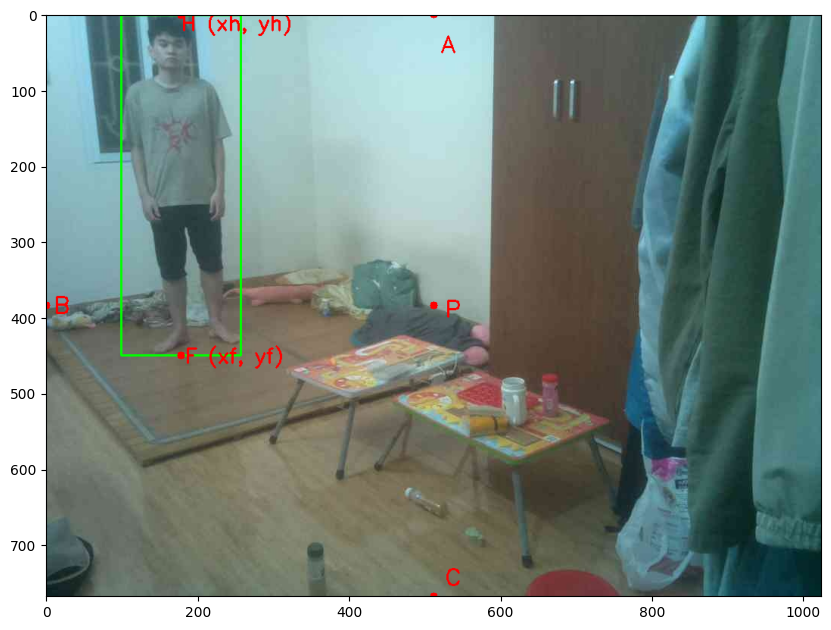

In [115]:
CONFIDENCE_THRESHOLD = 0.8
GREEN = (0, 255, 0)

detections = model(img, verbose=False)[0]
for data in detections.boxes.data.tolist():
        # extract the confidence (i.e., probability) associated with the detection
        confidence = data[4]

        # filter out weak detections by ensuring the 
        # confidence is greater than the minimum confidence
        if float(confidence) < CONFIDENCE_THRESHOLD:
            continue

        # if the confidence is greater than the minimum confidence,
        # draw the bounding box on the frame
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        cv2.rectangle(img, (xmin, ymin) , (xmax, ymax), GREEN, 2)
xf = int(0.5 * (xmin + xmax))
yf = int(ymax)

xh = int (0.5 * (xmin + xmax))
yh = int(ymin)
F = (xf, yf, 0)

cv2.circle(img, (xf, yf), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (xh, yh), radius=5, color=(0, 0, 255), thickness=-1)

cv2.circle(img, (B[0], B[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (A[0], A[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (P[0], P[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (C[0], C[1]), radius=5, color=(0, 0, 255), thickness=-1)

cv2.putText(img, "F (xf, yf)", (xf + 5, yf + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2.putText(img, "H (xh, yh)", (xh, yh + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

cv2.putText(img, "B", (B[0] + 10, B[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(img, "A", (A[0] + 10, A[1] + 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(img, "P", (P[0] + 15, P[1] + 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.putText(img, "C", (C[0] + 15, C[1] - 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

$$
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
=
\begin{bmatrix}
zc.u \\
zc.v \\
zc
\end{bmatrix}
= 
\begin{bmatrix}
fx & 0 & ox & 0 \\
0 & fy & oy & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}

\begin{bmatrix}
xc \\
yc \\
zc \\
1
\end{bmatrix}
$$

Means<br>
$$
\frac{xc}{zc}
=
\frac{u - ox}{fx}
$$

$$
\frac{yc}{zc}
=
\frac{v - oy}{fy}
$$

In [116]:
xc_over_zc = (xf - ox) / fx
yc_over_zc = (yf - oy) / fy

Pc = np.array([[xc_over_zc], [yc_over_zc], [1], [1]])


```latex
R: Rotation matrix. 
t: Translation vector. 
```
$$
Xc = R.Xw + t   
$$

$$
\begin{bmatrix}
xc \\
yc \\
zc
\end{bmatrix}
=
\begin{bmatrix}
r11 & r12 & r13 \\
r21 & r22 & r23 \\
r31 & r32 & r33
\end{bmatrix}
.
\begin{bmatrix}
xw \\
yw \\
zw
\end{bmatrix}
+
\begin{bmatrix}
tx \\
ty \\
tz
\end{bmatrix}
$$

```latex

Set P is the origin of the world coordinate system. 
P: [0, 0, 0] 

Human's foot: [xw, yw, zw] 

Assume the person is on the ground, hence zw = 0. 
So, the Person's coordinates are: [xw, yw, 0] 

The Camera's coordinates are: [0, h, -H]


In [117]:
h = 2.5      # m
cw = np.array([[0], [h], [-H]])
t = -np.dot(rotation_matrix, cw)
print("t \n {}\n".format(t))
tx, ty, tz = t[0][0], t[1][0], t[2][0]
rotation_matrix_env = np.linalg.inv(rotation_matrix)
print("R_inv  \n {}\n".format(rotation_matrix_env))
r31 = rotation_matrix_env[2][0]
r32 = rotation_matrix_env[2][1]
r33 = rotation_matrix_env[2][2]

zc = (r31*tx + r32*ty + r33*tz) / (r31*xc_over_zc + r32*yc_over_zc + r33)
xc = zc * xc_over_zc
yc = zc * yc_over_zc
Xc = np.array([[xc], [yc], [zc]])

Xw = np.dot(rotation_matrix_env, Xc - t)
print(np.round(Xw, 6))

t 
 [[     -2.517]
 [     1.0814]
 [    0.48355]]

R_inv  
 [[   0.059281    -0.28925     0.95542]
 [    0.99808    0.034296   -0.051546]
 [  -0.017857     0.95664     0.29072]]

[[     1.8996]
 [     2.2243]
 [         -0]]


##### Visualization

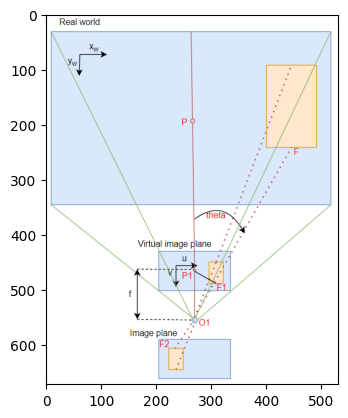

In [118]:
visualize_img1 = cv2.imread(r'D:\python\Distance_measurement\visualize\visualize1.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img1, cv2.COLOR_BGR2RGB))
plt.show()

##### Angle calculation

In [119]:
PFx = (F[0] - P[0])*pixcel_w
PFy = (F[1] - P[1])*pixcel_h
PF = math.sqrt(PFx**2 + PFy**2)
print("PF: {} mm".format(PF))
theta = math.degrees(math.atan(PF/f))
print("theta = {} degree".format(theta))


PF: 1.2199902069761863 mm
theta = 20.345671557949252 degree


Read distance measurement

   UAV height  h1 (m)  h2 (m)  Distance from UAV (m)
0        0.44    0.64    0.88                   1.52
1        0.76    1.10    1.40                   2.50
2        0.81    1.22    1.70                   2.92
3        1.00    1.36    1.56                   3.10
4        1.22    1.61    2.59                   4.20


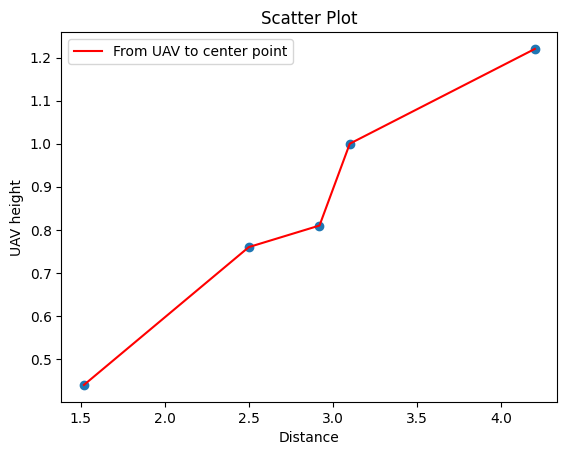

In [124]:
df = pd.read_csv(r'D:\python\Distance_measurement\visualize\real_distance.csv')
# To display the first 5 rows of the dataframe
print(df.iloc[:, :4])
y_val = df.iloc[:, 0]
x_val = df.iloc[:, 3]
plt.scatter(x_val, y_val)
# Draw a red line connecting the dots
plt.plot(x_val, y_val, color='red', label = "From UAV to center point")
# Add labels and title
plt.xlabel('Distance')
plt.ylabel('UAV height')
plt.title('Scatter Plot')
plt.legend()

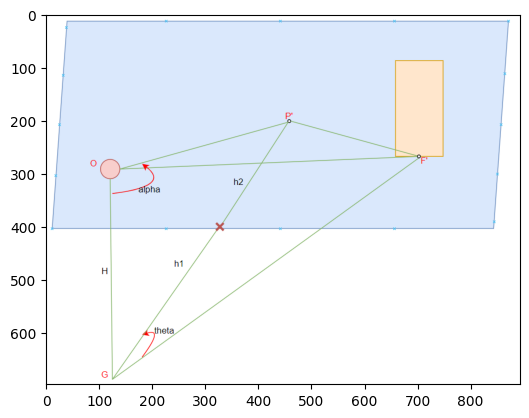

In [121]:
visualize_img2 = cv2.imread(r'D:\python\Distance_measurement\visualize\visualize2.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img2, cv2.COLOR_BGR2RGB))
plt.show()

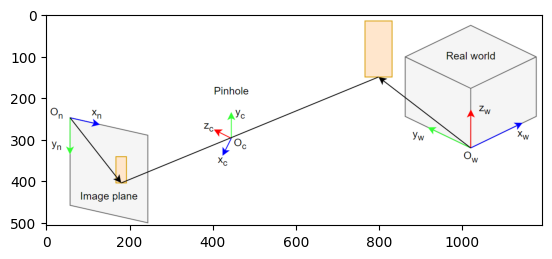

In [122]:
visualize_img3 = cv2.imread(r'D:\python\Distance_measurement\visualize\visualize3.png')
# Display the image
plt.imshow(cv2.cvtColor(visualize_img3, cv2.COLOR_BGR2RGB))
plt.show()

In [123]:
m = folium.Map(location=[UAV_lat, UAV_lon], zoom_start=30)
folium.Marker(location=[UAV_lat, UAV_lon], popup='UAV').add_to(m)

length = 0.0001
end_lat = UAV_lat + length * math.cos(math.radians(p))
end_lon = UAV_lon + length * math.sin(math.radians(p))
if ox < xf:
    end_lat_direct = UAV_lat + length * math.cos(math.radians(p + theta))
    end_lon_direct = UAV_lon + length * math.sin(math.radians(p + theta))
else:
    end_lat_direct = UAV_lat + length * math.cos(math.radians(p - theta))
    end_lon_direct = UAV_lon + length * math.sin(math.radians(p - theta))

# Draw the compass line
folium.PolyLine([(UAV_lat, UAV_lon), (end_lat, end_lon)], color="red").add_to(m)
# Draw the direct line
folium.PolyLine([(UAV_lat, UAV_lon), (end_lat_direct, end_lon_direct)], color="blue").add_to(m)

m    